In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.interpolate import pchip
import scipy.signal as sgn
import pickle

def draw_bounds(ax, model):
    bounds = np.where(np.diff(np.argmax(model.segments_[0], axis=1)))[0]
    bounds_aug = np.concatenate(([0],bounds,[model.segments_[0].shape[0]]))
    for i in range(len(bounds_aug)-1):
        rect = patches.Rectangle((bounds_aug[i], bounds_aug[i]), bounds_aug[i+1]-bounds_aug[i], 
                                 bounds_aug[i+1]-bounds_aug[i], linewidth=1, edgecolor='#FFF9AE', 
                                 facecolor='none')
        ax.add_patch(rect)
    return ax


%matplotlib inline

## Set path

In [2]:
datadir = '../../../data/processed/'

## Load data

In [3]:
video_model, recall_models = np.load(datadir+'models_t100_v50_r10.npy')
video_events = np.load(datadir+'video_events.npy')
with open(datadir+'video_eventseg_model', 'rb') as f:
    video_eventseg_model = pickle.load(f)
with open(datadir+'recall_eventseg_models', 'rb') as f:
    recall_event_models = pickle.load(f)
recall_events = np.load(datadir+'recall_events.npy')
avg_recall_events = np.load(datadir+'avg_recall_events.npy')

## Plot figure

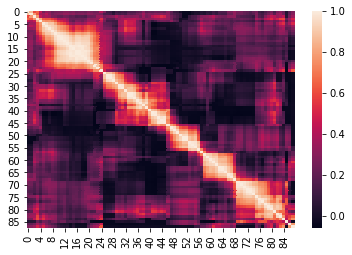

In [4]:
h = sns.heatmap(pd.DataFrame(recall_models[0]).T.corr())

In [5]:
def parse_diag(M):
    n = M.shape[1]
    x = np.nan * np.zeros([M.shape[0], 2 * n + 1])
    
    for i in np.arange(n):
        x[i, (n - i):n] = M[i, 0:i]
        x[i, n] = M[i, i]
        x[i, (n+1):(n + n - i)] = M[i, (i+1):]
    
    return pd.DataFrame(x, columns=np.arange(-n, n+1))

In [6]:
M = pd.DataFrame(recall_models[0]).T.corr().values
np.fill_diagonal(M, np.nan)
x = parse_diag(M)

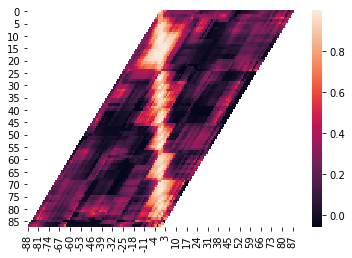

In [7]:
h = sns.heatmap(x)

In [8]:
def plot_ribbon(x, color='k', ribbon_alpha=0.2):
    mean = x.mean()
    ci = 1.96 * np.divide(x.std(), np.sqrt(x.shape[0]))
    
    xvals = x.columns
    h = plt.gcf()
    plt.fill_between(xvals, mean - ci, mean + ci, color=color, alpha=ribbon_alpha)
    plt.plot(mean, color=color)
    
    return h

def resample(x, axis=0, nbins=100):
    if type(axis) is list:
        if len(axis) == 0:
            return x
        else:
            if not(type(nbins) is list):
                nbins = [nbins] * len(axis)
            x = resample(x, axis[0], nbins=nbins[0])
            for i in np.arange(1, len(axis)):
                x = resample(x, axis[i], nbins=nbins[i])
            return x
    
    if axis == 1:
        return resample(x.T, axis=0, nbins=nbins).T
    elif not (axis == 0):
        raise Exception('resampling must be along axis 0 or 1')
    
    vals = np.array(x.axes[axis])
    minval = np.min(vals)
    maxval = np.max(vals)
    
    newvals = np.linspace(minval, maxval, nbins)
    normed_newvals = np.divide(newvals, np.max([np.abs(minval), np.abs(maxval)]))    
    
    y = np.zeros([nbins, x.shape[1]])
    for i in np.arange(x.shape[1]):
        y[:, i] = pchip(vals, x.iloc[:, i], extrapolate=False)(newvals)
    
    return pd.DataFrame(y, index=normed_newvals, columns=x.columns)

def autocorr_plot(r, color='k', res=False, nbins=101):
    M = pd.DataFrame(r).T.corr().values
    x = parse_diag(M).loc[:, 0:]
    if res:
        h = plot_ribbon(resample(x.iloc[:, 1:-1], axis=1, nbins=nbins), color=color)
        plt.xlabel('Relative time')
    else:
        h = plot_ribbon(x.iloc[:, 1:-1], color=color)
        plt.xlabel('Time')
    
    plt.ylabel('Correlation')
    return h

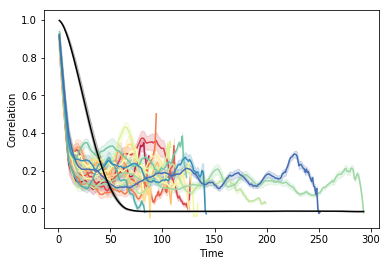

In [10]:
colors = sns.color_palette('Spectral', n_colors=len(recall_models))
max_length = np.max([x.shape[0] for x in recall_models])
for i, r in enumerate(recall_models):
    autocorr_plot(r, color=colors[i], res=False);
autocorr_plot(video_model[0:max_length], color='k', res=False);
plt.gcf().savefig('/mnt/reinstatement.pdf')

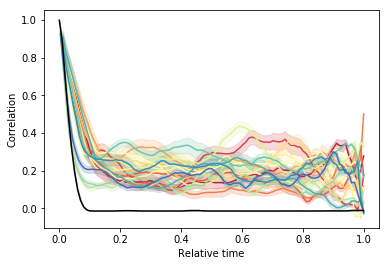

In [11]:
for i, r in enumerate(recall_models):
    autocorr_plot(r, color=colors[i], res=True);
autocorr_plot(video_model, color='k', res=True);
plt.gcf().savefig('/mnt/reinstatement_resampled.pdf')

In [19]:
def plot_corrmat(c, vmin=0, vmax=1):
    n = c.shape[0]
    ticks = np.linspace(0, n, 5)
    sns.heatmap(c, vmin=vmin, vmax=vmax)
    plt.xlabel('Relative time')
    plt.ylabel('Relative time')
    plt.xticks(ticks, np.divide(ticks, n))
    plt.yticks(ticks, np.divide(ticks, n))

In [13]:
n = 100
recall_corrs = np.zeros([n, n])
all_recall_corrs = []
for i, r in enumerate(recall_models):
    x = resample(pd.DataFrame(r).T.corr(), axis=[0, 1], nbins=n)
    recall_corrs += x
    all_recall_corrs.append(x)
recall_corrs = np.divide(recall_corrs, len(recall_models))

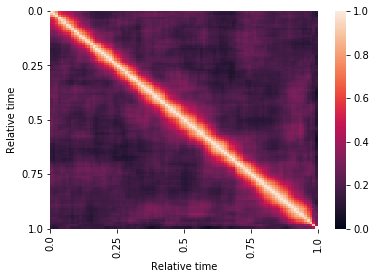

In [18]:
plot_corrmat(recall_corrs)
plt.gcf().savefig('/mnt/all_recall_corrs.pdf')

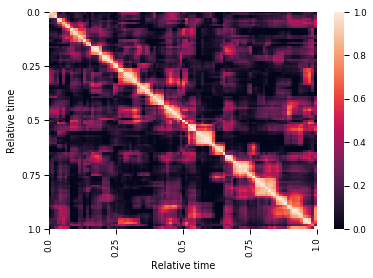

In [118]:
for i, r in enumerate(all_recall_corrs):
    plt.close()
    plot_corrmat(r)
    plt.gcf().savefig(f'/mnt/S{i}_corrs.pdf')

In [16]:
vid_corrs = resample(pd.DataFrame(video_model).T.corr(), axis=[0, 1], nbins=n)

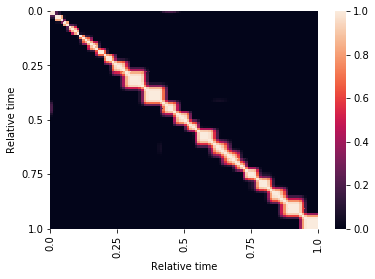

In [23]:
plot_corrmat(vid_corrs)
plt.gcf().savefig('/mnt/video_corrs.pdf')